In [1]:
#%matplotlib inline
%matplotlib notebook

from __future__ import print_function
import gzip
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from six.moves import cPickle as pickle
from sklearn.manifold import TSNE
from collections import Counter

plt.style.use('ggplot')

In [2]:
def gc(sequence):
    sequence = sequence.upper()
    return (sequence.count('G') + sequence.count('C')) / float(len(sequence))


def seq_entropy(sequence):
    bases = {'A', 'C', 'G', 'T'}
    c = Counter(sequence.upper())
    tot = float(sum([c[b] for b in bases]))
    c = {b: c[b]/tot for b in bases}
    
    return sum([(-c[b]) * np.log2(c[b]) for b in bases if c[b] > 0])


def patten2number(sequence):
    """ Converts DNA sequence into an int. """
    BASE_TO_NUMBER = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    if len(sequence) == 0:
        return 0
    last_base = sequence[-1]
    prefix = sequence[:-1]
    return 4 * patten2number(prefix) + BASE_TO_NUMBER[last_base]
    

def number2patten(number, kmer_size):
    """ Converts an int into a string with k nucleotides. """
    NUMBER_TO_BASE = ('A', 'C', 'G', 'T')
    if kmer_size == 1:
        return NUMBER_TO_BASE[number]
    prefix_index = number // 4
    base = NUMBER_TO_BASE[number % 4]
    return number2patten(prefix_index, kmer_size - 1) + base

In [26]:
seq_entropy('AAAAAATG')

1.0612781244591329

### Load Embeddings

In [58]:
#pickle_file = '../Kmer2vec/6-mers/6mers_1padding_32embedding_epoch1_batch0.pickle'
pickle_file = '../Kmer2vec/6-mers/6mers_1padding_16embedding_epoch1_batch0.pickle'
with open(pickle_file, 'rb') as f:
    pre_normalized_embeddings = pickle.load(f)
pickle_file = '../Kmer2vec/6-mers/6mers_1padding_16embedding_epoch4_batch11865094.pickle'
with open(pickle_file, 'rb') as f:
    post_normalized_embeddings = pickle.load(f)

print(pre_normalized_embeddings.shape)
print(post_normalized_embeddings.shape)

(4096, 16)
(4096, 16)


### Save Normalized Embeddings to NumPy .npy Format

In [64]:
with open('../Kmer2vec/6-mers/6mers_1padding_16embedding_epoch4_batch11865094.npy', 'wb') as npy:
    np.save(npy, post_normalized_embeddings)

### Convert into 2D Space (t-distributed stochastic neighbor embedding (t-SNE))

In [42]:
KMER_SIZE = 6
#NUM_POINTS = 5000

#random_kmers = np.random.choice(4**KMER_SIZE, NUM_POINTS, replace=False)
#random_kmers.sort()
#print(len(random_kmers), random_kmers[:10])

In [43]:
# Subset
#labels = random_kmers  # Needs to be sorted

# All
labels = xrange(4**KMER_SIZE)

labels_entropy = [seq_entropy(number2patten(s, KMER_SIZE)) for s in labels]
labels_gc = [gc(number2patten(s, KMER_SIZE)) for s in labels]

# Frequence in hg38
labels_frequence = {}
for kmer in gzip.open('../hg38_Vocabulary/vocabulary_{}mers.sorted.tsv.gz'.format(KMER_SIZE)):
    seq, freq = kmer.split()
    seq = patten2number(seq)
    freq = int(freq)
    if seq in labels:
        labels_frequence[seq] = freq
    
labels_frequence = [np.log10(labels_frequence[k]) for k in sorted(labels_frequence.keys())]

# Frequence in hg38 LINE
labels_frequence_line = {}
for kmer in gzip.open('../hg38_Vocabulary/UCSC_hg38_LINE_Vocabulary_{}mers.tsv.gz'.format(KMER_SIZE)):
    seq, freq = kmer.split()
    seq = patten2number(seq)
    freq = int(freq)
    if seq in labels:
        labels_frequence_line[seq] = freq

labels_frequence_line = [np.log10(labels_frequence_line[k]) for k in sorted(labels_frequence_line.keys())]
    
# Frequence in hg38 SINE
labels_frequence_sine = {}
for kmer in gzip.open('../hg38_Vocabulary/UCSC_hg38_SINE_Vocabulary_{}mers.tsv.gz'.format(KMER_SIZE)):
    seq, freq = kmer.split()
    seq = patten2number(seq)
    freq = int(freq)
    if seq in labels:
        labels_frequence_sine[seq] = freq

labels_frequence_sine = [np.log10(labels_frequence_sine[k]) for k in sorted(labels_frequence_sine.keys())]

    
print(len(labels_entropy), labels_entropy[:10])
print(len(labels_gc), labels_gc[:10])
print(len(labels_frequence), labels_frequence[:10])
print(len(labels_frequence_line), labels_frequence_line[:10])
print(len(labels_frequence_sine), labels_frequence_sine[:10])

4096 [0.0, 0.65002242164835411, 0.65002242164835411, 0.65002242164835411, 0.65002242164835411, 0.91829583405448956, 1.2516291673878228, 1.2516291673878228, 0.65002242164835411, 1.2516291673878228]
4096 [0.0, 0.16666666666666666, 0.16666666666666666, 0.0, 0.16666666666666666, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333]
4096 [7.0065561436586297, 6.3569151541011095, 6.4632075764531987, 6.6816431356666932, 6.4582848318814374, 6.1248177687495335, 5.4012678194119426, 6.2919661495134598, 6.4720709809190549, 6.125945566126604]
4096 [6.243156905024601, 5.8011902838335292, 5.8813738135403923, 6.0365766012422499, 5.8800036783549201, 5.6130612928514303, 4.7174125120406751, 5.7274355170359987, 5.9401786796693097, 5.546342743305277]
4096 [6.6299772769541789, 5.2563520729082596, 5.3975593999749307, 5.9662013561046594, 5.3830214251730757, 4.9990347944751914, 4.1479853206838051, 5.0349972297663301, 5.4179165548471433, 4.6183723883517107]


In [59]:
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=5000)

## Subset
#pre_two_d_embeddings = tsne.fit_transform([pre_normalized_embeddings[s, :] for s in random_kmers])
#post_two_d_embeddings = tsne.fit_transform([post_normalized_embeddings[s, :] for s in random_kmers])

## All
pre_two_d_embeddings = tsne.fit_transform(pre_normalized_embeddings)
post_two_d_embeddings = tsne.fit_transform(post_normalized_embeddings)

<IPython.core.display.Javascript object>


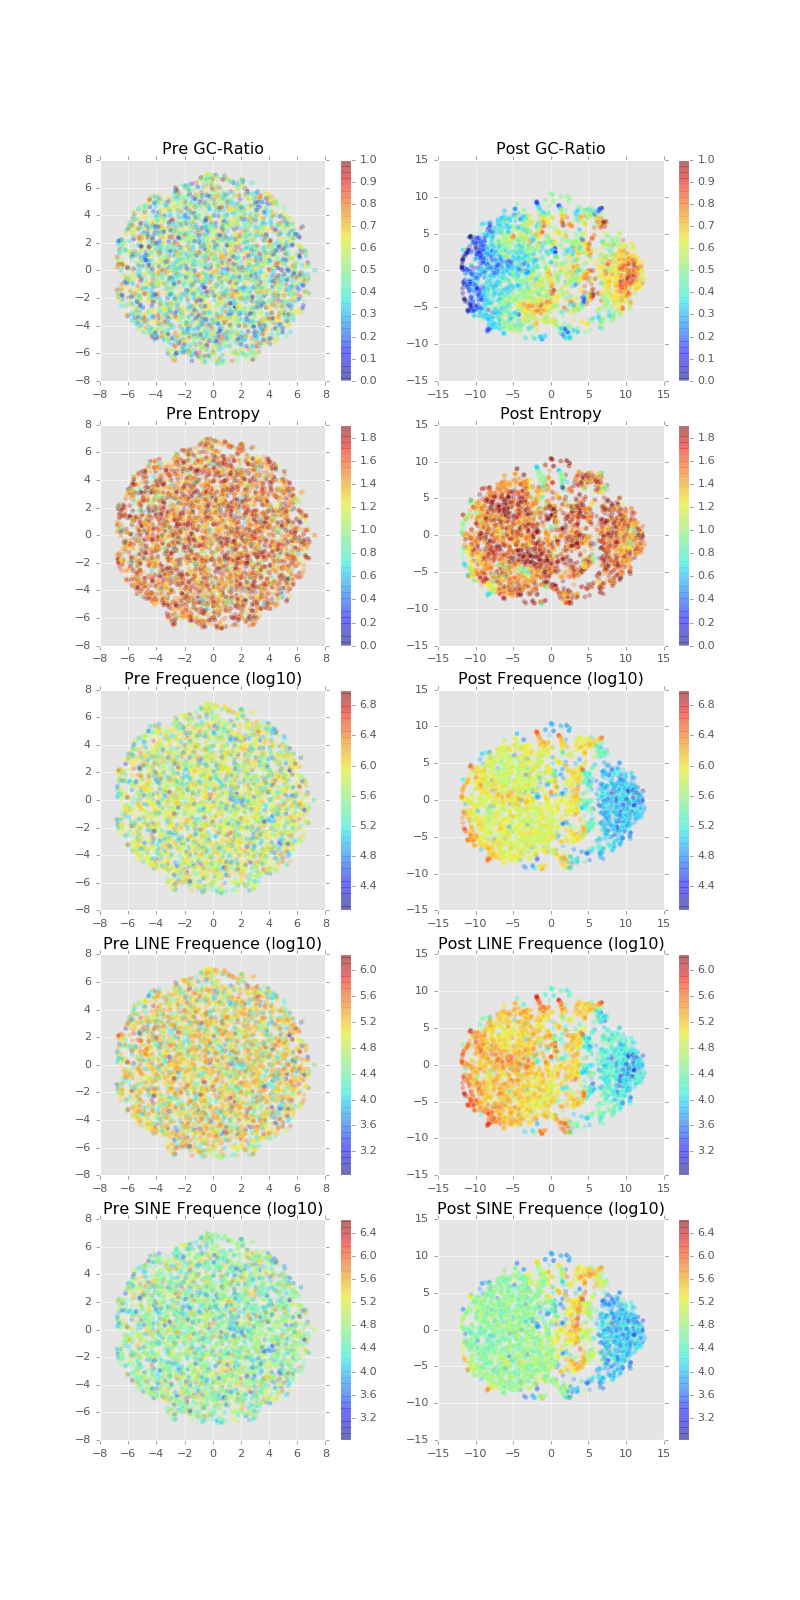

In [60]:
def plot(x, y, labels, title):
    norm = colors.Normalize(vmin=min(labels), vmax=max(labels))
    plt.scatter(x, y, c=labels, alpha=0.3, cmap=plt.get_cmap('jet'), norm=norm)
    plt.colorbar()
    plt.title(title)

pre_x = pre_two_d_embeddings[:, 0]
pre_y = pre_two_d_embeddings[:, 1]

post_x = post_two_d_embeddings[:, 0]
post_y = post_two_d_embeddings[:, 1]

plt.figure(figsize=(10, 20))  # in inches

plt.subplot(5,2,1)
plot(pre_two_d_embeddings[:, 0], pre_two_d_embeddings[:, 1], labels_gc, 'Pre GC-Ratio')

plt.subplot(5,2,2)
plot(post_two_d_embeddings[:, 0], post_two_d_embeddings[:, 1], labels_gc, 'Post GC-Ratio')

plt.subplot(5,2,3)
plot(pre_two_d_embeddings[:, 0], pre_two_d_embeddings[:, 1], labels_entropy, 'Pre Entropy')

plt.subplot(5,2,4)
plot(post_two_d_embeddings[:, 0], post_two_d_embeddings[:, 1], labels_entropy, 'Post Entropy')

plt.subplot(5,2,5)
plot(pre_two_d_embeddings[:, 0], pre_two_d_embeddings[:, 1], labels_frequence, 'Pre Frequence (log10)')

plt.subplot(5,2,6)
plot(post_two_d_embeddings[:, 0], post_two_d_embeddings[:, 1], labels_frequence, 'Post Frequence (log10)')

plt.subplot(5,2,7)
plot(pre_two_d_embeddings[:, 0], pre_two_d_embeddings[:, 1], labels_frequence_line, 'Pre LINE Frequence (log10)')

plt.subplot(5,2,8)
plot(post_two_d_embeddings[:, 0], post_two_d_embeddings[:, 1], labels_frequence_line, 'Post LINE Frequence (log10)')

plt.subplot(5,2,9)
plot(pre_two_d_embeddings[:, 0], pre_two_d_embeddings[:, 1], labels_frequence_sine, 'Pre SINE Frequence (log10)')

plt.subplot(5,2,10)
plot(post_two_d_embeddings[:, 0], post_two_d_embeddings[:, 1], labels_frequence_sine, 'Post SINE Frequence (log10)')


plt.show()

### 3D

In [61]:
tsne_3d = TSNE(perplexity=50, n_components=3, init='pca', n_iter=5000)

#post_3d_embeddings = tsne_3d.fit_transform([post_normalized_embeddings[s, :] for s in random_kmers])

# All
post_3d_embeddings = tsne_3d.fit_transform(post_normalized_embeddings)

<IPython.core.display.Javascript object>


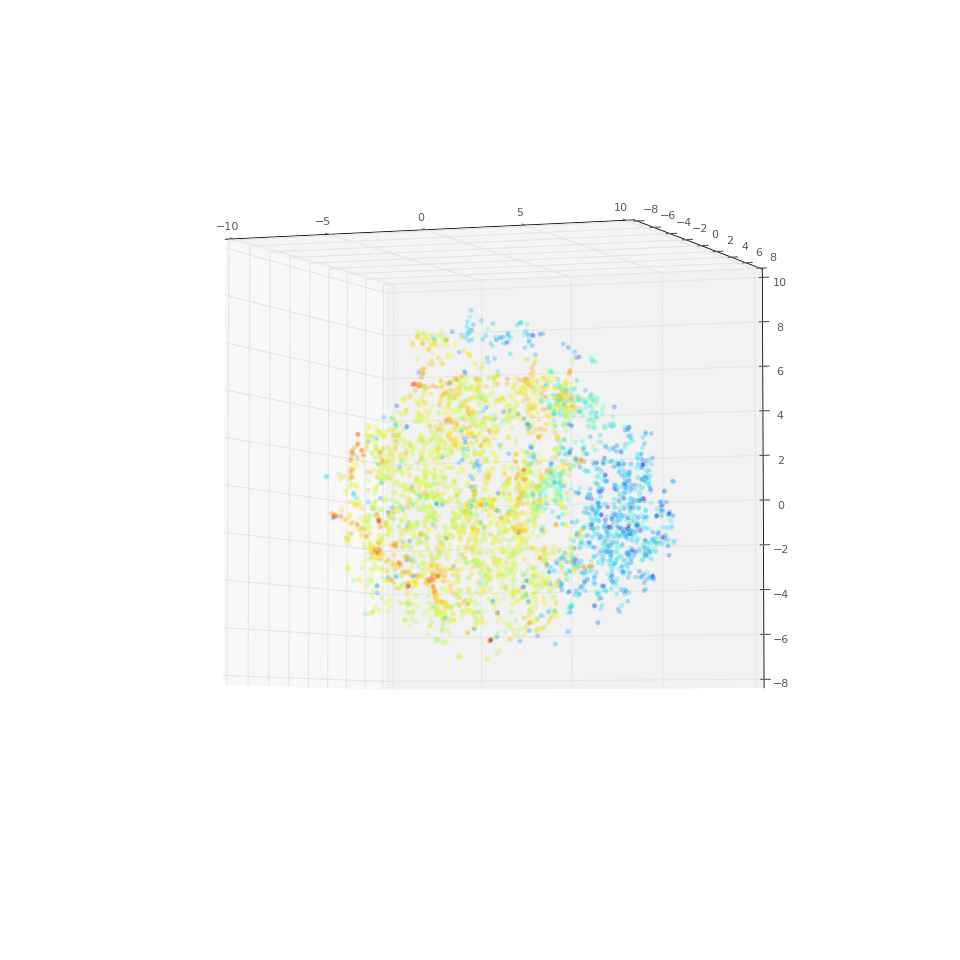

In [62]:
post_x = post_3d_embeddings[:, 0]
post_y = post_3d_embeddings[:, 1]
post_z = post_3d_embeddings[:, 2]

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
plt.gca().patch.set_facecolor('white')

label_type = labels_frequence

norm = colors.Normalize(vmin=min(label_type), vmax=max(label_type))
ax.scatter(post_x, post_y, post_z, alpha=0.3, c=label_type, cmap=plt.get_cmap('jet'), norm=norm)

plt.show()